# Preparations

In [1]:
import sys
import math
import numpy as np

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings

In [3]:
colors = ['C' + str(i) for i in range(10)]

# Data for baseline

In [2]:
metrics_filenames = ['logr', 'ce', 'scores']
metrics_labels = [r'MSE $\log \ r$', 'Cross entropy', 'MSE scores']
n_metrics = len(metrics_filenames)
metrics_min = [0., 0.657, 0.]
metrics_max = [0.18, 0.675, 3.5]

strategies_filenames = ['carl', 'combined', 'regression', 'combinedregression',
                        'carl_smeared', 'combined_smeared', 'regression_smeared','combinedregression_smeared']
strategies_folders = ['parameterized'] * len(strategies_filenames)
strategies_labels = ['carl', 'carl + score', 'ratio regression', 'ratio regr. + score'] * 2
strategies_panel = [0, 0, 0, 0, 1, 1, 1, 1]
n_panels = max(strategies_panel) + 1


In [4]:
metrics = []  # Indexed by [strategy][metric][train/validation][epoch]
result_dir = '../results'

for sfile, sfolder in zip(strategies_filenames, strategies_folders):
    line = []
    for met in metrics_filenames:
        line.append(np.load(result_dir + '/' + sfolder + '/traininghistory_' + met + '_' + sfile + '.npy') )
    metrics.append(line)

# Baseline results

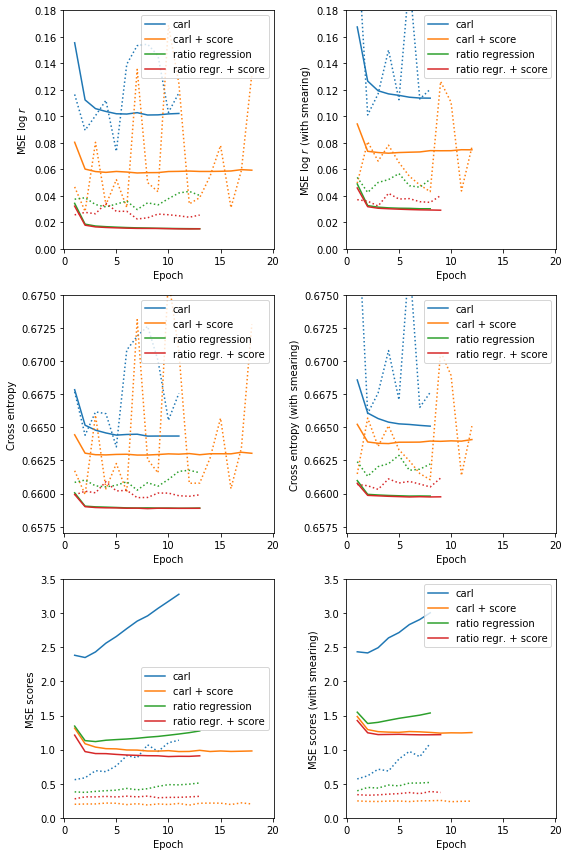

In [5]:
plt.figure(figsize=(n_panels*4., n_metrics*4))

for p in range(n_panels):

    for m, mlabel in enumerate(metrics_labels):
        
        plt.subplot(n_metrics, n_panels, m * n_panels + p + 1)
        i = 0
        
        for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
            if spanel != p:
                continue
                
            # Training data
            _y = metrics[s][m][0]
            _x = np.array(list(range(len(_y)))) + 1
            plt.plot(_x, _y, c=colors[i], ls='-', label=slabel)

            # Validation set
            _y = metrics[s][m][1]
            _x = np.array(list(range(len(_y)))) + 1
            plt.plot(_x, _y, c=colors[i], ls=':')
            
            i += 1
        
        plt.legend()
        
        plt.ylim(metrics_min[m],metrics_max[m])
        plt.xlim(-0.1,20.1)
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel(mlabel)
        else:
            plt.ylabel(mlabel + ' (with smearing)')

plt.tight_layout()
plt.savefig('../figures/learning_curves/learning_curves.pdf')

# Physics-aware

In [6]:
metrics_filenames = ['logr', 'ce', 'scores']
metrics_labels = [r'MSE $\log \ r$', 'Cross entropy', 'MSE scores']
n_metrics = len(metrics_filenames)
metrics_min = [0., 0.657, 0.]
metrics_max = [0.18, 0.675, 3.5]

strategies_filenames = ['regression_aware']
strategies_folders = ['parameterized']
strategies_labels = ['ratio regr. + score']


In [7]:
metrics = []  # Indexed by [strategy][metric][train/validation][epoch]
result_dir = '../results'

for sfile, sfolder in zip(strategies_filenames, strategies_folders):
    line = []
    for met in metrics_filenames:
        line.append(np.load(result_dir + '/' + sfolder + '/traininghistory_' + met + '_' + sfile + '.npy') )
    metrics.append(line)

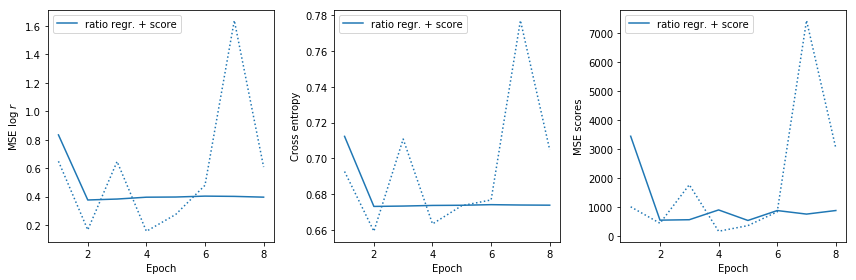

In [11]:
plt.figure(figsize=(n_metrics*4., 1*4))

for m, mlabel in enumerate(metrics_labels):

    plt.subplot(1, n_metrics, m + 1)

    for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):

        # Training data
        _y = metrics[s][m][0]
        _x = np.array(list(range(len(_y)))) + 1
        plt.plot(_x, _y, c=colors[s], ls='-', label=slabel)

        # Validation set
        _y = metrics[s][m][1]
        _x = np.array(list(range(len(_y)))) + 1
        plt.plot(_x, _y, c=colors[s], ls=':')

    plt.legend()

    #plt.ylim(metrics_min[m],metrics_max[m])
    #plt.xlim(-0.1,20.1)

    plt.xlabel('Epoch')
    plt.ylabel(mlabel)

plt.tight_layout()
plt.savefig('../figures/learning_curves/learning_curves_aware.pdf')